In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('png')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks");

# Homework 2

## References

+ Module 3: Uncertainty Propagation Through Scientific Models
   - Local sensitivity analysis
   - Global sensitivity analysis

## Instructions

+ Type your name and email in the "Student details" section below.
+ Develop the code and generate the figures you need to solve the problems using this notebook.
+ For the answers that require a mathematical proof or derivation you should type them using latex. If you have never written latex before and you find it exceedingly difficult, we will likely accept handwritten solutions.
+ The total homework points are 100. Please note that the problems are not weighed equally.

## Student details

+ **First Name: Shaunak**
+ **Last Name: Mukherjee**
+ **Email: mukher86@purdue.edu**
+ **Used generative AI to complete this assignment (Yes/No): No**
+ **Which generative AI tool did you use (if applicable)?: NA**

## Problem 1 - Local sensitivity analysis of nonlinear dynamical system

Consider the Duffing oscillator:

$$\ddot{x} + \delta \dot{x} + \alpha x + \beta x^3 = \gamma \cos(\omega t)$$

where $\delta$, $\alpha$, $\beta$, $\gamma$, and $\omega$ are constants. As a system of first order equations, introducing $v = \dot{x}$, we have:

$$\begin{align}
\dot{x} & = v \\
\dot{v} & = \gamma \cos(\omega t) - \delta v - \alpha x - \beta x^3
\end{align}$$

The initial conditions are $x(0) = x_0$ and $v(0) = v_0$.
Denote by $\theta$ the **vector of all parameters and initial conditions**, i.e. $\theta = (x_0, v_0, \alpha, \beta, \gamma, \delta, \omega)$.
The vector field $f(x,v,t;\theta)$ is then given by:

$$f(x,v,t;\theta) = \begin{pmatrix}
v \\
\gamma \cos(\omega t) - \delta v - \alpha x - \beta x^3
\end{pmatrix}.$$

### Part A: Implement the Duffing oscillator
Modify the code of [this example](https://predictivesciencelab.github.io/advanced-scientific-machine-learning/up/sensitivity_analysis/03_example_ode.html) to create a solver that takes $\theta$ as an input and returns the solution of the Duffing oscillator for a given the interval of time $[0, 50]$ with a time step of 0.1.
Make sure your code can be vectorized with respect to $\theta$ and that it can be `jit`ed.

**Answer:**

In [8]:
alpha, beta, gamma, delta, omega = theta[:5]
theta[:5]

Array([1.  , 5.  , 0.37, 0.1 , 1.  ], dtype=float32)

In [4]:
# Your code and evidence that it works here

# Import libraries  
import numpy as np
import jax.numpy as jnp
from diffrax import diffeqsolve, Tsit5, ODETerm, SaveAt

def vector_field_duff_oscil(t, f, theta):
    alpha, beta, gamma, delta, omega = theta[:5]
    x = y[0]
    v = y[1]
    return jnp.array(
        [
            v,
            - alpha * x - beta * x ** 3 - delta * v + gamma * jnp.cos(omega * t)
        ]
    )


theta = jnp.array([
    1.0,  # alpha
    5.0,  # beta
    0.37, # gamma
    0.1,  # delta
    1.0,  # omega
])

# The numerical solver to use.
solver = Tsit5()
# At which timesteps to store the solution.
saveat = SaveAt(ts=jnp.linspace(0, 50, 2000))
# The differential equation term.
term = ODETerm(vector_field_duff_oscil)
# The Solution for one theta.
sol = diffeqsolve(
    term,
    solver,
    t0=0,                       # Initial time
    t1=50,                      # Terminal time
    dt0=0.1,                    # Initial timestep - it will be adjusted
    y0=jnp.array([0.0, 0.0]),   # Initial value
    args=theta,
    saveat=saveat
)

In [9]:
print(sol.ys.shape)


(2000, 2)


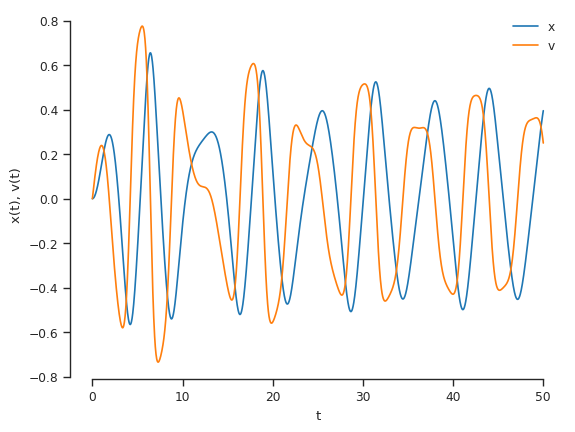

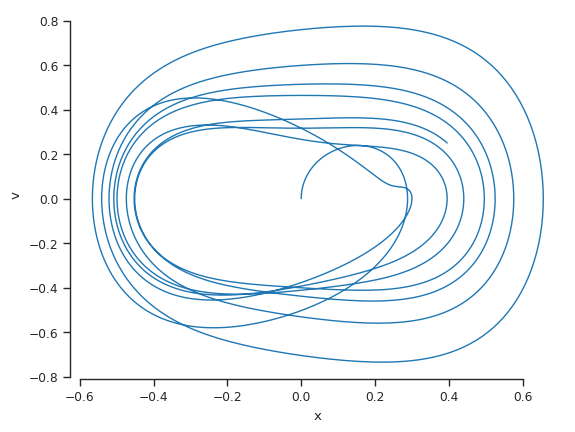

In [10]:
fig, ax = plt.subplots()
ax.plot(sol.ts, sol.ys[:, 0], label="x")
ax.plot(sol.ts, sol.ys[:, 1], label="v")
ax.set(xlabel="t", ylabel="x(t), v(t)")
ax.legend(frameon=False)
sns.despine(trim=True);

fig, ax = plt.subplots()
ax.plot(sol.ys[:, 0], sol.ys[:, 1], lw=1)
ax.set(xlabel="x", ylabel="v")
sns.despine(trim=True);

### Part B: Plot the strange attractor

Fix the values of the parameters to: $\alpha = 1$, $\beta = 5, \gamma = 8, \delta = 0.02$, and $\omega = 0.5$. Use the solver you implemented in Part A to plot the [strange attractor](https://en.wikipedia.org/wiki/Attractor#Strange_attractor) of the Duffing oscillator. To do this, just sample the initial conditions $x_0$ and $v_0$ from a uniform distribution in the interval $[-1, 1]$ and do the scatter plot of the points $(x(t), v(t))$ at $t = 50$. It looks like [this](https://en.wikipedia.org/wiki/Duffing_equation#/media/File:Forced_Duffing_equation_Poincaré_section.png).

Hint: Just make a 2D array of $\theta$'s with the first two columns randomly sampled and the rest fixed. Then pass the samples through your vectorized and `jit`ed solver and plot the results.

**Answer:**

In [ ]:
# Your response in code and markdown cells here

### Part C: Local sensitivity analysis

Suppose you have a 1\% uncertainty about $\alpha, \beta, \delta, \gamma, \omega$ and 5\% uncertainty about the initial conditions $x_0$ and $v_0$. You can model this uncertainty with the Gaussian random variable:

$$
\theta \sim \mathcal{N}\left(
\begin{pmatrix}
0.5\\
0.5\\
1 \\
5 \\
0.37 \\
0.1 \\
1
\end{pmatrix},
\begin{pmatrix}
0.025^2 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0.025^2 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0.01^2 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0.05^2 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0.0037^2 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0.001^2 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0.01^2
\end{pmatrix}
\right)
$$

+ Use local sensitivity analysis to propagate this uncertainty through the Duffing oscillator.
+ Use your results to plot 95\% credible intervals of $x(t)$ and $v(t)$ as functions of time for $t \in [0, 10]$.
+ Plot the estimated mean and variance of $x(t)$ and $v(t)$ as functions of time for $t \in [0, 30]$ and compare to Monte Carlo estimates using $10^5$ samples. For how long does the local sensitivity analysis give a good approximation of the mean and variance?

**Answer:**

In [ ]:
# Your response in code and markdown cells here

### Part D: Local sensitivity analysis results in a Gaussian process approximation of the uncertain dynamical system

As we discussed in the [theory](https://predictivesciencelab.github.io/advanced-scientific-machine-learning/up/sensitivity_analysis/01_theory.html), local sensitivity analysis results in a (vector-valued) Gaussian process.

+ Plot the covariance of $x(t)$ with $x(0)$, i.e., plot the function:

    $$
    g(t) = \text{Cov}[x(t), x(0)] = \nabla_\theta x(t)\Sigma \nabla_\theta x(0)^\top,
    $$

    for $t$ in $[0, 5]$.
    (Recall $x$ is the *position* of the oscillator.)

+ Take five (5) samples from the Gaussian process corresponding to $x(t)$ and plot them as functions of time for $t \in [0, 5]$. Hint: The mean is just the local sensitivity analysis estimate of the mean. Then you will have to find the covariance matrix of $x(t_i)$, for $t_i$ points in $[0,5]$, and sample from the corresponding multivariate Gaussian distribution.
(And don't forget to add some jitter to the diagonal of the covariance matrix for numerical stability.)

**Answer:**

In [ ]:
# Your response in code and markdown cells here

### Part E: Global sensitivity analysis

Sobol sensitivity indices are a popular way to quantify the importance of the parameters of a model.
The caveat is that they assume that the inputs of the model are independent and uniformly distributed.
So, before applying the method, we will have to transform the random variables $\theta_i$ to uniform random variables $\xi_i$.

+ Find random variables $\xi_i$ and transformation functions $F_i$, such that $\xi_i \sim U(0, 1)$ and $\theta_i = F_i^{-1}(\xi_i)$. Explicitly write down what what are these transformation functions. Hint: Recall that if $X$ is a random variable with CDF $F_X$, then $Y = F_X(X)$ is a random variable with uniform distribution in $[0, 1]$.
+ Implement a solver that takes $\xi$ as an input and returns the solution of the Duffing oscillator for a given the interval of time $[0, 50]$ with a time step of 0.1.
+ Compute the first order Sobol sensitivity indices for the Duffing oscillator using the solver you just implemented. Make sure you have used enough samples to get a convergent estimate of the Sobol indices. You can use the [SALib](https://salib.readthedocs.io/en/latest/) library to do this.

**Answer:**

In [ ]:
# Your response in code and markdown cells here